## Loading medical image data
In this notebook, the non-scoliotic and scoliotic data for the project is showcased. This data can be used to write an algorithm to find the optimal viewing angle for clinicians using a C-arm.

In [29]:
# Library imports
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import os
import cv2

from image_utils import *
from scipy.ndimage import rotate

## Bone MRI DICOM images

In [2]:
# Define path of patient dataset
patient_path = "boneMRI/20240119_BoneMRI_EBS23"

# Load dicom data
dicom_image = load_3d_dicom(patient_path)
print(f"The shape of the image is {dicom_image.shape}")

The shape of the image is (100, 672, 672)


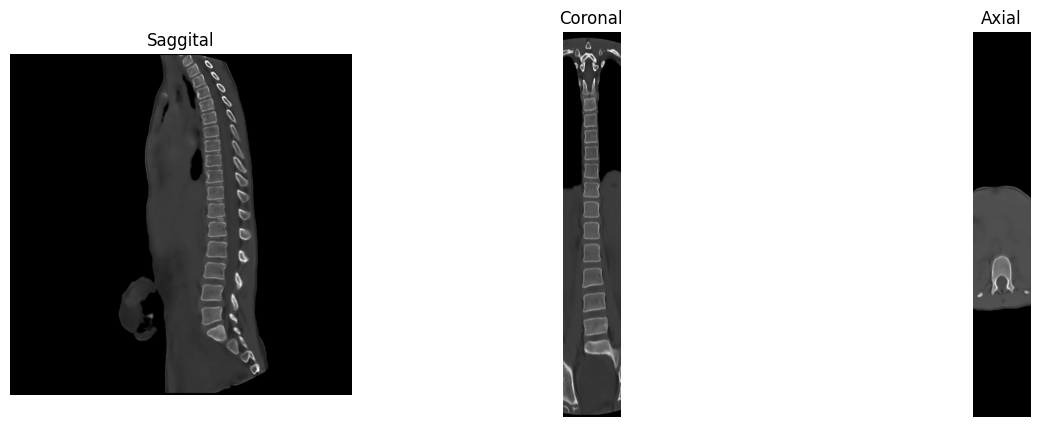

In [3]:
def plot_bonemri(image, window_level, window_width, slice_idx=None):
    # Get middle slices if slice_idx not specified
    if slice_idx is None:
        slice_idx = {
            "sagittal": image.shape[0] // 2,
            "axial": image.shape[1] // 2,
            "coronal": image.shape[2] // 2
        }

    # Apply window and normalize to 0-255
    image = apply_window(image, window_level, window_width)

    # Create figure with one row and two columns
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    [axes.set_axis_off() for axes in ax.flatten()]

    # Sagittal Slice
    ax[0].imshow(image[slice_idx["sagittal"],:,:], cmap="gray")
    ax[0].set_title("Saggital")
    # Axial Slice
    ax[2].imshow(np.rot90(image[:,slice_idx["axial"],:], 3), cmap="gray")
    ax[2].set_title("Axial")
    # Coronal Slice
    ax[1].imshow(np.rot90(image[:,:,slice_idx["coronal"]], 3), cmap="gray")
    ax[1].set_title("Coronal")

    plt.show()

slice_idx = {
    "sagittal": dicom_image.shape[0] // 2,
    "axial": dicom_image.shape[1] // 2,
    "coronal": 400
}
plot_bonemri(image=dicom_image, window_level=450, window_width=1500, slice_idx=slice_idx)

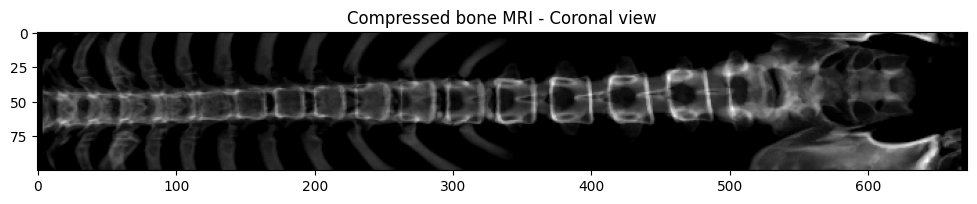

In [ ]:
def compress_bonemri(image, window_level, window_width, compress_axis=0):
    # Apply window and normalize to 0-255
    image = apply_window(image, window_level, window_width)

    threshold_min = 100  # Lower limit
    threshold_max = 255  # Upper limit

    # Apply thresholding (set values outside range to 0)
    binary_image = np.where((image >= threshold_min) & (image <= threshold_max), image, 0)

    # Compress the 3D image to 2D using max projection
    compressed_image = np.sum(binary_image, axis=compress_axis)

    # Plot
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(compressed_image, cmap="gray")
    ax.set_title("Compressed bone MRI - Coronal view")

    plt.show()

# Example usage
compress_bonemri(dicom_image, window_level=450, window_width=1500, compress_axis=2)

In [39]:
def pad_to_cube(image, axis, target_depth=None):
    """Pads a 3D image to a cube shape (target_size, target_size, target_size)."""
    
    if axis not in [0, 1, 2]:
        raise ValueError("Axis must be 0, 1, or 2")
    
    if target_depth is None:
        target_depth = max(image.shape)
        
    current_depth = image.shape[axis]
    
    
    if current_depth >= target_depth:
        return image  # No padding needed if already large enough
    
    # Compute padding for depth (only pad the first axis)
    pad_before = (target_depth - current_depth) // 2
    pad_after = target_depth - current_depth - pad_before
    
    min_intensity = np.min(image)  # Use min intensity instead of 0 to avoid artifacts

    if target_depth is None:
        target_depth = max(image.shape)
    
    if axis == 0:
        # Apply padding only along depth (first axis)
        padded_image = np.pad(image, [(pad_before, pad_after), (0, 0), (0, 0)], 
                                    mode='constant', constant_values=min_intensity)   
    elif axis == 1:
        # Apply padding only along width (second axis)
        padded_image = np.pad(image, [(0, 0), (pad_before, pad_after), (0, 0)], 
                                    mode='constant', constant_values=min_intensity)
    else:
        # Apply padding only along height (third axis)
        padded_image = np.pad(image, [(0, 0), (0, 0), (pad_before, pad_after)], 
                                    mode='constant', constant_values=min_intensity) 
    
    return padded_image

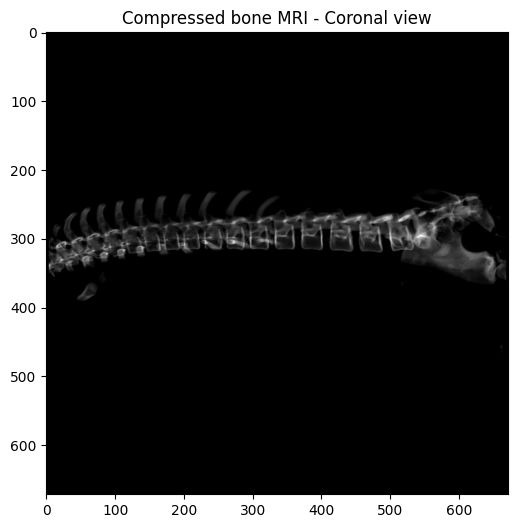

In [46]:
def rotate_image(image: np.ndarray, axis: int, angle: float):
    """
    Rotate a 3D image along a given axis using OpenCV for faster processing.

    Parameters
    ----------
    image : np.ndarray
        The 3D image to rotate.
    axis : int
        The axis along which to rotate the image (0 = sagittal, 1 = coronal, 2 = axial).
    angle : float
        The angle (in degrees) by which to rotate the image. (Can be positive or negative)

    Returns
    -------
    np.ndarray
        The rotated 3D image.
    """
    
    # Pad image to cube before rotation
    image = pad_to_cube(image, axis=0, target_depth=672)
    
    # Get image shape
    d, h, w = image.shape

    # Select rotation plane
    if axis == 0:  # Sagittal: Rotate along Y-Z
        slices = [image[i, :, :] for i in range(d)]
    elif axis == 1:  # Coronal: Rotate along X-Z
        slices = [image[:, i, :] for i in range(h)]
    elif axis == 2:  # Axial: Rotate along X-Y
        slices = [image[:, :, i] for i in range(w)]
    else:
        raise ValueError("Invalid axis. Use 0, 1, or 2.")
    
    # Get rotation matrix for 2D rotation
    center = (slices[0].shape[1] // 2, slices[0].shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply rotation to each slice
    rotated_slices = [
        cv2.warpAffine(slice_, rotation_matrix, (slice_.shape[1], slice_.shape[0]), flags=cv2.INTER_LINEAR)
        for slice_ in slices
    ]

    # Stack back to 3D
    if axis == 0:
        rotated_image = np.stack(rotated_slices, axis=0)
    elif axis == 1:
        rotated_image = np.stack(rotated_slices, axis=1)
    elif axis == 2:
        rotated_image = np.stack(rotated_slices, axis=2)
 
    compress_bonemri(rotated_image, window_level=450, window_width=1500, compress_axis=2)

    return rotated_image



# Example Usage
rotated_image = rotate_image(image=dicom_image, axis=1, angle=30)